In [4]:
import sys
sys.path.append('./helper_scripts/')# make script files in ml-ex3 accessible

In [5]:
from data_loaders import CIFAR10Loader

To evaluate a given feature we use a self written function that tests some classifiers and evaluates their performance on the passed feature:

In [6]:
from traditional_ml import evaluate_feature

# Color Histograms

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = CIFAR10Loader('./data/CIFAR-10').get_processed_imgs(target_width = 32, target_height = 32, normalize=False)

CIFAR-10 dataset already downloaded, loading files from memory
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


For the purposes of traditional feature extraction we do not need a validation set so let's append it to our training set:

In [4]:
import numpy as np

X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

In [6]:
from PIL import Image

def get_color_hist_from_image(image):
    res = Image.fromarray(image).convert('RGB')
    return res.histogram()

In [7]:
X_train = [get_color_hist_from_image(i) for i in X_train]
X_test = [get_color_hist_from_image(i) for i in X_test]

In [8]:
evaluate_feature(X_train, y_train, X_test, y_test)

Trying KNeighborsClassifier()
Fitted, best are {'clf__n_neighbors': 25, 'clf__weights': 'distance'} with cross val score of 0.29606000000000005.
Accuracy on Test Set is 0.2998
Trying MLPClassifier()


C:\Users\andre\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitted, best are {'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate': 'adaptive', 'clf__learning_rate_init': 0.01} with cross val score of 0.25926.
Accuracy on Test Set is 0.2702
Trying GaussianNB()
Fitted, best are {} with cross val score of 0.24009999999999998.
Accuracy on Test Set is 0.2481
Trying DecisionTreeClassifier()
Fitted, best are {'clf__criterion': 'gini', 'clf__splitter': 'best'} with cross val score of 0.19316.
Accuracy on Test Set is 0.1957
Trying RandomForestClassifier(random_state=123)
Fitted, best are {'clf__criterion': 'gini', 'clf__n_estimators': 100} with cross val score of 0.3256.
Accuracy on Test Set is 0.3296
Best Classifier is (RandomForestClassifier(random_state=123), {'clf__criterion': 'gini', 'clf__n_estimators': 100}) with an accuracy of 0.3296, predicting took 1.210282325744629 seconds and this whole process took 00:29:03.70


So using color histograms we can achieve an accuracy of 32.96% on this test set. How long does the RandomForest Model take to train?

In [10]:
from sklearn import ensemble
import time

cl = ensemble.RandomForestClassifier(random_state=123, criterion='gini', n_estimators=100)
ping = time.time()
cl = cl.fit(X_train, y_train)
print(f"Fit Time: {time.time()-ping} seconds")

Fit Time: 47.48492121696472 seconds


# SIFT BOVW

In [14]:
!pip install opencv-contrib-python==3.4.2.17

ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==3.4.2.17 (from versions: 3.4.8.29, 3.4.9.31, 3.4.9.33, 3.4.10.35, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.59, 3.4.17.61, 4.1.2.30, 4.2.0.32, 4.2.0.34, 4.3.0.36, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62)
ERROR: No matching distribution found for opencv-contrib-python==3.4.2.17


In [1]:
from typing import List
import sklearn.metrics.pairwise as sklearn_pairwise
from sklearn.neighbors import KNeighborsClassifier
import cv2
import numpy as np
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans
import matplotlib.pyplot as plt

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = CIFAR10Loader('./data').get_processed_imgs(target_width = 50, target_height = 50, normalize=False, convert_to_grayscale=True)

CIFAR-10 dataset already downloaded, loading files from memory
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


In [8]:
X_train_int = X_train.astype(np.uint8)
X_test_int = X_test.astype(np.uint8)

In [9]:
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color),
                       cmap='gray', vmin=0, vmax=255)

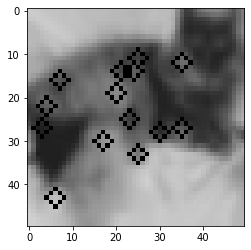

In [10]:
sift=cv2.SIFT_create()
kp = sift.detect(X_train_int[1],None)
kp, des = sift.compute(X_train_int[1], kp)
img=draw_keypoints(X_train_int[1],kp)

In [13]:
def extract_dsift(images):
    sift = cv2.SIFT_create()
    
    all_descriptors = []
    nans = set()
    for i in range(len(images)):
        image = images[i]
        kp = sift.detect(image,None)
        kp, des = sift.compute(image, kp)

        if des is not None:
            all_descriptors.append(des)
        else:
            nans.add(i)

    print(len(nans))
    return all_descriptors, nans

In [14]:
sift_features, nans = extract_dsift(X_train_int)
all_descriptors = np.vstack(sift_features)

8


In [16]:
len(X_train)

35000

In [17]:
kmeans = KMeans(n_clusters=20).fit(all_descriptors)

## Creating Histogram of training image

In [15]:
def count_visual_words(dense_feat: List[np.ndarray], centroids: List[np.ndarray]) -> List[np.ndarray]:
    histograms = []

    for k in range(0, len(dense_feat)):
        distances = sklearn_pairwise.pairwise_distances(dense_feat[k], centroids)
        clusters = np.argmin(distances, axis=1)
        histogram = np.histogram(clusters, bins = range(len(centroids)))
        histograms.append(histogram[0])

    return histograms

In [18]:
histograms_train = count_visual_words(sift_features, kmeans.cluster_centers_)

In [19]:
def get_data_without_nan(data, nan):
    without_nan = []

    for i in range(len(data)):
        if i not in nan:
            without_nan.append(y_train[i])

    return without_nan

In [20]:
y_train_sift = get_data_without_nan(y_train, nans)

## Test The Histograms as Features for classification:

In [21]:
test_descriptors, test_nan = extract_dsift(X_test_int)
test_histograms = count_visual_words(test_descriptors, kmeans.cluster_centers_)

0


In [22]:
y_test_sift = get_data_without_nan(y_test, test_nan)

In [23]:
evaluate_featureate_feature(histograms_train, y_train_sift, test_histograms, y_test_sift)

Trying KNeighborsClassifier()
Fitted, best are {'clf__n_neighbors': 25, 'clf__weights': 'distance'} with cross val score of 0.24662791209996476.
Accuracy on Test Set is 0.0946
Trying MLPClassifier()
Fitted, best are {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate': 'adaptive', 'clf__learning_rate_init': 0.01} with cross val score of 0.27746364043922334.
Accuracy on Test Set is 0.0923
Trying GaussianNB()
Fitted, best are {} with cross val score of 0.24794259384868642.
Accuracy on Test Set is 0.0997
Trying DecisionTreeClassifier()
Fitted, best are {'clf__criterion': 'entropy', 'clf__splitter': 'best'} with cross val score of 0.16592355638442777.
Accuracy on Test Set is 0.1003
Trying RandomForestClassifier(random_state=123)
Fitted, best are {'clf__criterion': 'gini', 'clf__n_estimators': 100} with cross val score of 0.26503214173290013.
Accuracy on Test Set is 0.0962
Best Classifier is (DecisionTreeClassifier(), {'clf__criterion': 'entropy', 'clf__splitte

We get an accuracy of 10.03% which is just slightly better than randomly guessing (our classes are evenly distributed and we have 10 classes).

In [26]:
from sklearn import tree
import time

cl = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
ping = time.time()
cl = cl.fit(histograms_train, y_train_sift)
print(f"Fit Time: {time.time()-ping} seconds")

Fit Time: 0.3300337791442871 seconds
